# Plots and figures for RTN-012

## Notebook boilerplate, imports, and setup

In [1]:
import logging
logging.basicConfig(format='%(asctime)s %(message)s')
logger = logging.getLogger(__name__)
logger.setLevel('DEBUG')
logger.info("Starting")

2021-05-07 16:22:23,768 Starting


In [160]:
logger.debug("Loading system modules")
import sys
import os
import random
import glob
from functools import lru_cache
from functools import partial
from configparser import ConfigParser
from copy import deepcopy

logger.debug("Loading third party modules")
import numpy as np
import pandas as pd
from numexpr import NumExpr
import tabulate

import matplotlib as mpl
import matplotlib.pyplot as plt

import healpy
import palpy
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.time import Time
import astropy.units as u

logger.debug("Loading Rubin Observatory modules")
import lsst.sims.utils
from lsst.sims.seeingModel import SeeingData, SeeingModel
from lsst.sims.cloudModel import CloudData
from lsst.sims.skybrightness_pre import SkyModelPre

logger.debug("Loading zernike module")
%load_ext autoreload
%autoreload 1
%aimport lsst.sims.skybrightness_pre.zernike
%aimport zernexam

2021-05-10 12:35:01,901 Loading system modules
2021-05-10 12:35:01,902 Loading third party modules
2021-05-10 12:35:01,961 Loading Rubin Observatory modules
2021-05-10 12:35:01,963 Loading zernike module


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
SITE = EarthLocation.of_site('Cerro Pachon')
SKY_DATA_PATH = '/data/des70.a/data/neilsen/sims_skybrightness_pre/data'
NEW_MOON_MJD = 60025.2
FULL_MOON_MJD = 60010.2
BANDS = ('u', 'g', 'r', 'i', 'z', 'y')
BAND_COLOR = {'u': '#56b4e9',
              'g': '#008060',
              'r': '#ff4000',
              'i': '#850000',
              'z': '#6600cc',
              'y': '#000000'}

In [4]:
plt.style.use('ggplot')

In [5]:
def nearest_value(value, data):
    nearest_index = (np.abs(data - value)).argmin()
    nearest = data[nearest_index]
    return nearest

## Example healpix-based sky maps

In [6]:
%%time
sky = pd.read_hdf('../data/resid_o7_z705_59823_60191.h5', 'i')

CPU times: user 27.3 s, sys: 37.3 s, total: 1min 4s
Wall time: 1min 4s


In [7]:
%%time
sky['laea_r'] = 2*np.cos(0.5*(np.pi/2 + np.radians(sky.alt)))
sky['zd'] = 90 - sky['alt']
sky['az_rad'] = np.radians(sky.az)

CPU times: user 2.63 s, sys: 3.11 s, total: 5.74 s
Wall time: 3.89 s


In [8]:
sky.columns

Index(['band', 'mjd', 'gmst', 'lst', 'alt', 'az', 'ra', 'decl', 'moon_ra',
       'moon_decl', 'moon_alt', 'moon_az', 'moon_sep', 'sun_ra', 'sun_decl',
       'sun_alt', 'sky', 'zsky', 'resid', 'laea_r', 'zd', 'az_rad'],
      dtype='object')

In [9]:
new_moon_mjd = nearest_value(NEW_MOON_MJD, sky.mjd.values)
full_moon_mjd = nearest_value(FULL_MOON_MJD, sky.mjd.values)

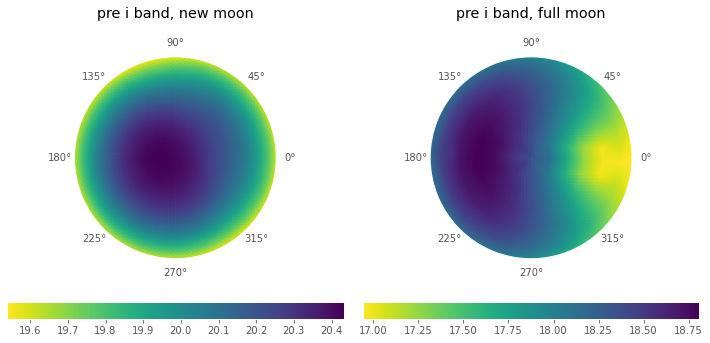

In [10]:
fig = plt.figure(figsize=(10, 5))
zernexam.map_sky(fig, 1, 2, 1, sky.loc[new_moon_mjd], 'sky', 'pre i band, new moon', radial_column='zd', cmap='viridis_r', s=15)
zernexam.map_sky(fig, 1, 2, 2, sky.loc[full_moon_mjd], 'sky', 'pre i band, full moon', radial_column='zd', cmap='viridis_r', s=15)
plt.tight_layout()

In [11]:
fig.savefig('healpix_map.png')

In [12]:
logger.debug("Made healpix_map.png")

2021-05-07 16:24:08,484 Made healpix_map.png


## Zernike basis functions

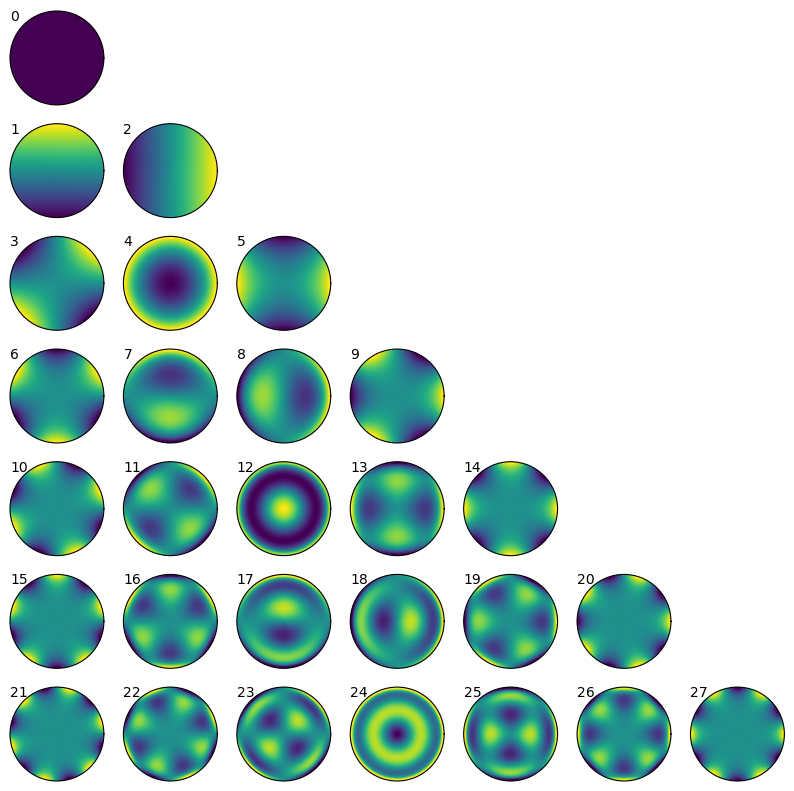

In [13]:
def plot_zernike_basis(zern_order):
    zsky = lsst.sims.skybrightness_pre.zernike.ZernikeSky(order=zern_order, max_zd=70.5)
    zero_coeffs = pd.DataFrame({n:float(0) for n in np.arange(np.sum(np.arange(zsky.order) + 1))}, index=[60000])
    zero_coeffs.index.name = 'mjd'

    with plt.style.context('default'):
        fig = plt.figure(figsize=(10, 10))
        sphere_npix = healpy.nside2npix(zsky.nside)
        sphere_ipix = np.arange(sphere_npix)
        az, alt = healpy.pix2ang(zsky.nside, sphere_ipix, lonlat=True)
        phi, rho = zsky._calc_phi(az), zsky._calc_rho(alt)
        good = rho<1
        alt, az, phi, rho = alt[good], az[good], phi[good], rho[good]

        n_terms = np.sum(np.arange(zsky.order) + 1)
        axes = []
        for j in np.arange(n_terms):
            n = np.ceil((-3 + np.sqrt(9 + 8 * j)) / 2).astype(int)
            mprime = 2 * j - n * (n + 2)
            m = np.abs(mprime)

            coeffs = zero_coeffs.copy()
            coeffs.loc[coeffs.index[0], j] = 1.0
            zsky._coeffs = coeffs

            sky = zsky.compute_sky(alt, az, mjd=60000)

            ax = fig.add_subplot(zsky.order, zsky.order, n*zsky.order+int((n+mprime)/2)+1, projection='polar')
            p = ax.scatter(phi, rho, c=sky, s=1)
            #ax.set_title(f"{j} = {n}, {mprime}")
            ax.annotate(f'{j}', (0, 0.9), xycoords='axes fraction')
            ax.set_ylim([0, 1])
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_xticks([])
            ax.set_yticks([])
            axes.append(ax)
            
    return fig, axes

fig, axes = plot_zernike_basis(7)

In [14]:
fig.savefig('basis7.png')

In [15]:
logger.debug("made basis7.png")

2021-05-07 16:24:21,666 made basis7.png


## Residual maps

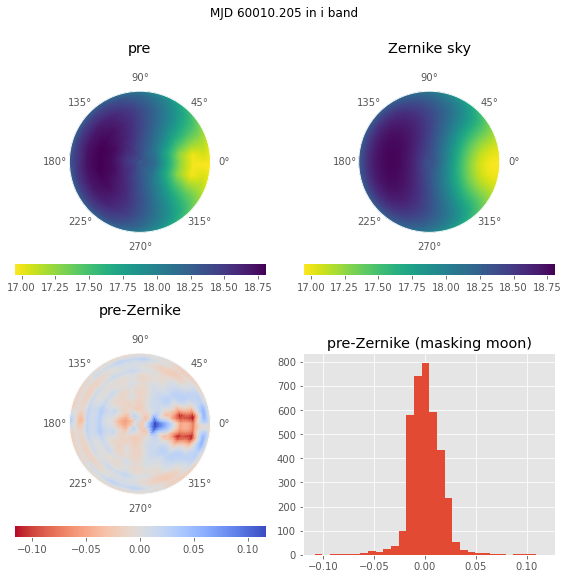

In [16]:
fig, axes = zernexam.resid_map(sky.loc[full_moon_mjd].copy(), full_moon_mjd, 'i')
plt.tight_layout()

In [17]:
fig.savefig('resid_full.png')

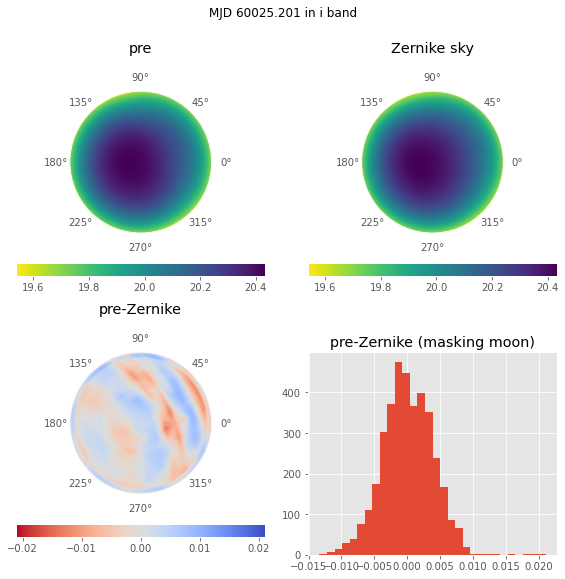

In [18]:
fig, axes = zernexam.resid_map(sky.loc[new_moon_mjd].copy(), new_moon_mjd, 'i')

In [19]:
fig.savefig('resid_new.png')

Find the MJD with the worst residual, and examine:

In [20]:
good_sky = sky.query('moon_sep>15')
max_abs_resid_idx = np.abs(good_sky.resid).argmax()

In [21]:
good_sky.iloc[max_abs_resid_idx].resid

-0.26174954086241087

In [22]:
worst_mjd = good_sky.iloc[max_abs_resid_idx].mjd

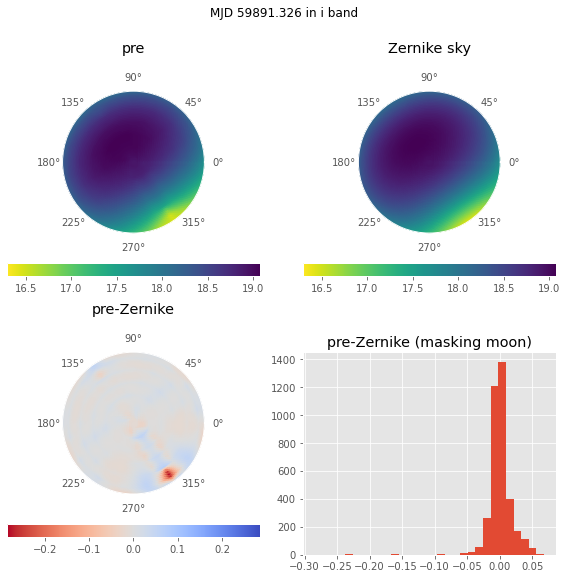

In [23]:
fig, axes = zernexam.resid_map(sky.loc[worst_mjd].copy(), worst_mjd, 'i')

In [24]:
fig.savefig('resid_worst.png')

In [25]:
sky.loc[worst_mjd, ['moon_alt', 'moon_az']].iloc[0]

moon_alt     20.596898
moon_az     305.169207
Name: (20.74237995448713, 0.0), dtype: float64

In [26]:
good_dark_sky = sky.query('moon_sep>15 and moon_alt<-8')
max_abs_resid_idx = np.abs(good_dark_sky.resid).argmax()
worst_dark_mjd = good_dark_sky.iloc[max_abs_resid_idx].mjd

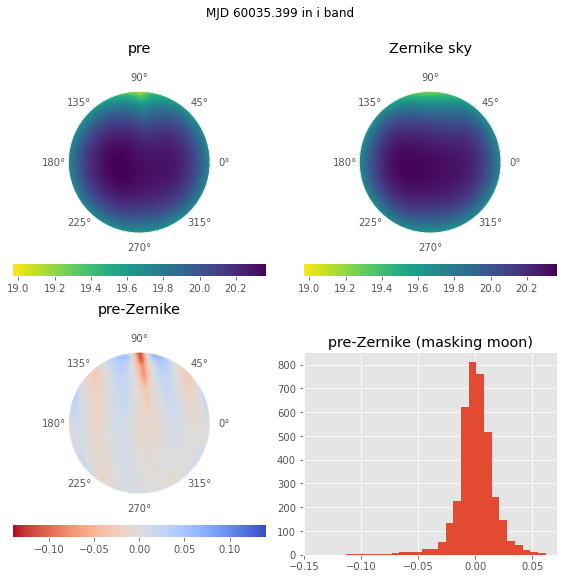

In [27]:
fig, axes = zernexam.resid_map(sky.loc[worst_dark_mjd].copy(), worst_dark_mjd, 'i')

In [28]:
fig.savefig('resid_worst_dark.png')

In [29]:
def sun_coords(mjd, telescope=lsst.sims.utils.Site("LSST")):
    gmst_rad = palpy.gmst(mjd)
    lst_rad = gmst_rad + telescope.longitude_rad
    ra_rad, decl_rad, _ = palpy.rdplan(mjd, 0, telescope.longitude_rad, telescope.latitude_rad)
    ha_rad = lst_rad - ra_rad
    az_rad, alt_rad = palpy.de2h(ha_rad, decl_rad, telescope.latitude_rad)
    az_deg, alt_deg = np.degrees(az_rad), np.degrees(alt_rad)
    return az_deg, alt_deg

sun_coords(worst_dark_mjd)

(95.25086885404023, -17.79373514000063)

In [30]:
Time(worst_dark_mjd, format='mjd', location=EarthLocation.of_site('Cerro Pachon')).iso

'2023-04-01 09:34:59.983'

### Moon near zenith

In [31]:
moon_zenith_mjd = sky.mjd.iloc[sky.moon_alt.argmax()]

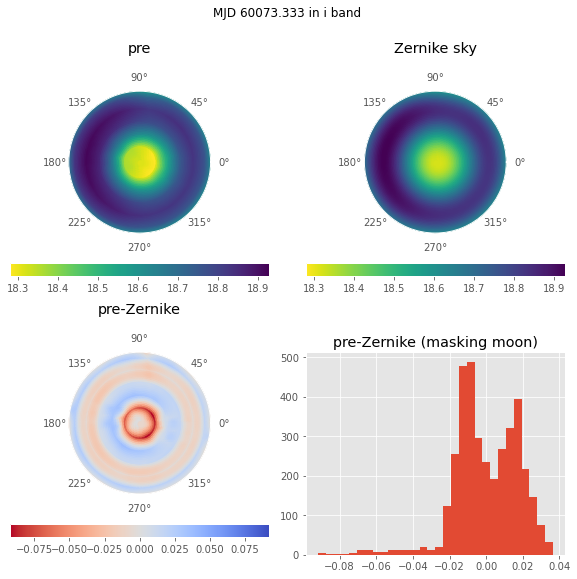

In [32]:
fig, axes = zernexam.resid_map(sky.loc[moon_zenith_mjd].copy(), moon_zenith_mjd, 'i')

In [33]:
fig.savefig('resid_zenith_moon.png')

## Historgrams of residuals with parameters

Text(0.5, 1.0, 'i band, 59823 < MJD < 60191')

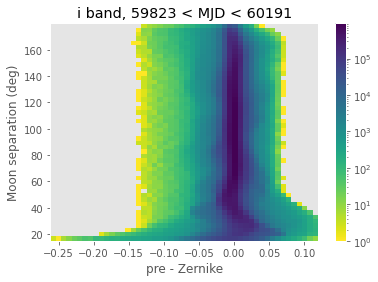

In [34]:
moon_sep_hist = zernexam.resid_2dhist(good_sky, 'moon_sep')
moon_sep_hist.ax.set_xlabel("pre - Zernike")
moon_sep_hist.ax.set_ylabel("Moon separation (deg)")
moon_sep_hist.ax.set_title("i band, 59823 < MJD < 60191")

In [35]:
moon_sep_hist.fig.savefig('moon_sep_hist.png')

Text(0.5, 1.0, 'i band, 59823 < MJD < 60191')

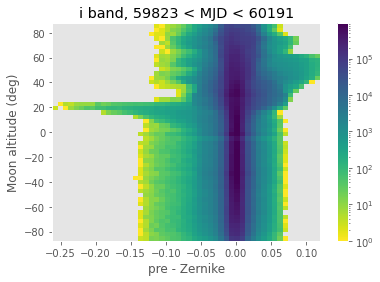

In [36]:
moon_alt_hist = zernexam.resid_2dhist(good_sky, 'moon_alt')
moon_alt_hist.ax.set_xlabel("pre - Zernike")
moon_alt_hist.ax.set_ylabel("Moon altitude (deg)")
moon_alt_hist.ax.set_title("i band, 59823 < MJD < 60191")

In [37]:
moon_alt_hist.fig.savefig('moon_alt_hist.png')

Text(0.5, 1.0, 'i band, 59823 < MJD < 60191, with moon')

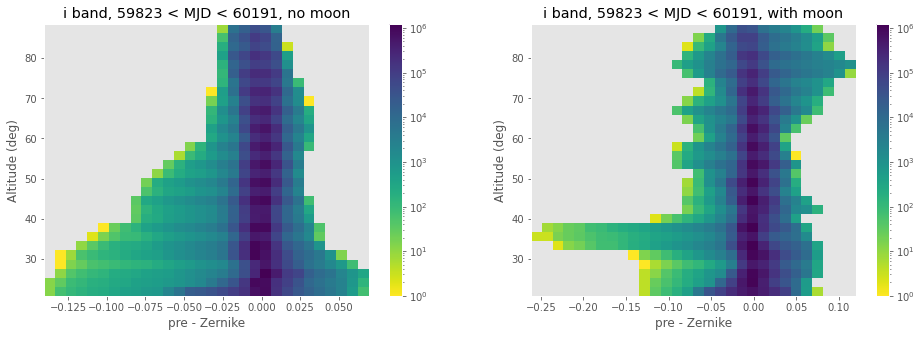

In [38]:
alt_hists = zernexam.resid_2dhist2(good_sky, 'alt', bins=30)
for alt_hist in alt_hists:
    alt_hist.ax.set_xlabel("pre - Zernike")
    alt_hist.ax.set_ylabel("Altitude (deg)")
alt_hists[0].ax.set_title("i band, 59823 < MJD < 60191, no moon")
alt_hists[1].ax.set_title("i band, 59823 < MJD < 60191, with moon")

In [39]:
alt_hists[0].fig.savefig('alt_hist.png')

What airmass corresponds to the poorly-performing altitudes?

In [40]:
#bad_alt = np.nanmax(good_sky.query('resid < -0.15').alt)
bad_alt = np.nanmax(good_sky.query('resid < -0.1').alt)

def compute_airmass(alt, a=470.0):
    mu = np.cos(np.radians(90-alt))
    x = np.sqrt(a*a*mu*mu + 2*a + 1) - a*mu
    return x

bad_alt, compute_airmass(bad_alt)

(40.228184728061095, 1.5460967765395708)

Checking if the poor dark sky residuals come from Zodiacal light:

In [41]:
%%time
def ecl(sky):
    lon_rad, lat_rad = palpy.eqeclVector(np.radians(sky.ra.values), np.radians(sky.decl.values), sky.mjd.values[0])
    ecl_coords = pd.DataFrame({'ecl_lon': np.degrees(lon_rad),
                               'ecl_lat': np.degrees(lat_rad),
                               'resid': sky.resid,
                               'alt': sky.alt,
                               'az': sky.az}).set_index(['alt', 'az'])
    return ecl_coords

good_dark_ecl = good_dark_sky.groupby(level='mjd').apply(ecl)

CPU times: user 46.1 s, sys: 10.2 s, total: 56.4 s
Wall time: 56.5 s


Text(0.5, 1.0, 'i band, dark, 59823 < MJD < 60191')

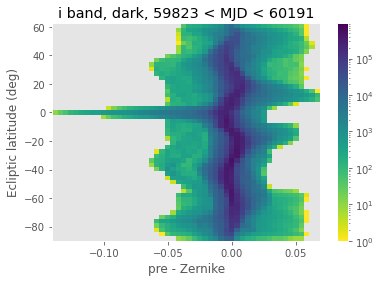

In [42]:
dark_ecl_lat_hist = zernexam.resid_2dhist(good_dark_ecl, 'ecl_lat')
dark_ecl_lat_hist.ax.set_xlabel("pre - Zernike")
dark_ecl_lat_hist.ax.set_ylabel("Ecliptic latitude (deg)")
dark_ecl_lat_hist.ax.set_title("i band, dark, 59823 < MJD < 60191")

In [43]:
dark_ecl_lat_hist.fig.savefig('dark_ecl_lat_hist.png')

## Full residuals

Free up some memory

In [90]:
del sky

In [91]:
resid_files = {'6th order': '../data/resid_z705_59823_60191.h5',
               '7th order': '../data/resid_o7_z705_59823_60191.h5',
               '12th order': '../data/resid_o12_59823_60191.h5'}
bands = 'ugrizy'
orders = ('6th order', '7th order', '12th order')

2021-05-10 12:45:42,091 Loading 6th order, u band
2021-05-10 12:47:09,817 Calculating stats
2021-05-10 12:47:12,027 Building histogram
2021-05-10 12:47:17,149 Loading 7th order, u band
2021-05-10 12:48:35,519 Calculating stats
2021-05-10 12:48:38,250 Building histogram
2021-05-10 12:48:43,768 Loading 12th order, u band
2021-05-10 12:50:14,388 Calculating stats
2021-05-10 12:50:16,807 Building histogram
2021-05-10 12:50:22,073 Loading 6th order, g band
2021-05-10 12:51:43,054 Calculating stats
2021-05-10 12:51:45,573 Building histogram
2021-05-10 12:51:50,832 Loading 7th order, g band
2021-05-10 12:53:21,977 Calculating stats
2021-05-10 12:53:24,669 Building histogram
2021-05-10 12:53:30,280 Loading 12th order, g band
2021-05-10 12:55:00,015 Calculating stats
2021-05-10 12:55:02,567 Building histogram
2021-05-10 12:55:07,858 Loading 6th order, r band
2021-05-10 12:56:25,330 Calculating stats
2021-05-10 12:56:27,807 Building histogram
2021-05-10 12:56:32,818 Loading 7th order, r band
202

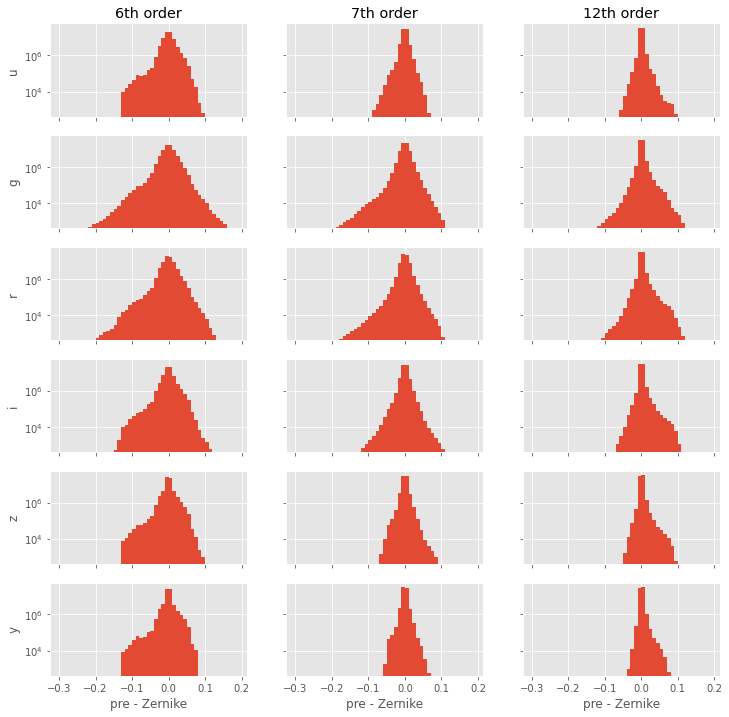

In [178]:
def plot_all_resid_hists(resid_files, bands, orders, in_sky=None):
    resid_stats = {}
    fig, axes = plt.subplots(len(bands), len(orders), figsize=(12, 12), sharex=True, sharey=True)
    for row, band in enumerate(bands):
        for col, order in enumerate(orders):
            logger.info(f"Loading {order}, {band} band")
            if in_sky is None:
                sky = pd.read_hdf(resid_files[order], band).query('moon_sep>30')
            else:
                sky = in_sky
            ax = axes[row, col] if isinstance(axes, np.ndarray) else axes
            logger.info("Calculating stats")
            these_resid_stats = sky.resid.describe(percentiles=[0.0001, 0.001, 0.01, 0.5, 0.99, 0.999, 0.9999])
            these_resid_stats['band'] = band
            these_resid_stats['order'] = order
            resid_stats[f'{order} {band}'] = these_resid_stats
            logger.info("Building histogram")
            ax.hist(sky.resid, bins=np.arange(-0.3, 0.2, 0.01), log=True)
            if row==0:
                ax.set_title(order)
            if col==0:
                ax.set_ylabel(band)
            if row==len(bands)-1:
                ax.set_xlabel("pre - Zernike")
            if in_sky is None:
                del sky
            
    return fig, axes, resid_stats
            
fig, axes, resid_stats = plot_all_resid_hists(resid_files, bands, orders)

In [179]:
fig.savefig('residual_hists.png')

In [190]:
with pd.option_context('display.float_format', '{:0.2f}'.format):
    resid_stats_df = (
        pd.DataFrame(resid_stats)
        .T
        .sort_values(['order', 'band'], key=lambda k: pd.Series([1,2,3,10,20,30,40,50,60], index=list(orders)+list(bands))[k])
        .set_index(['order', 'band'])
        .reset_index()
        .drop(columns=['count']))
    resid_stats_df['order'] = resid_stats_df['order'].str.replace(' order', '')
    table_str = tabulate.tabulate(resid_stats_df,
        headers=resid_stats_df.columns,
        tablefmt="rst",
        floatfmt='0.2f'
    )
    for line in table_str.split("\n"):
        print(line[6:])    

=======  ======  ======  =====  =====  =======  ======  =====  =====  =====  =======  ========  =====
order    band      mean    std    min    0.01%    0.1%     1%    50%    99%    99.9%    99.99%    max
=======  ======  ======  =====  =====  =======  ======  =====  =====  =====  =======  ========  =====
6th      u         0.00   0.02  -0.14    -0.12   -0.10  -0.04  -0.00   0.04     0.06      0.08   0.10
6th      g         0.00   0.02  -0.26    -0.16   -0.11  -0.05  -0.00   0.05     0.08      0.12   0.17
6th      r         0.00   0.02  -0.24    -0.15   -0.11  -0.05  -0.00   0.05     0.08      0.10   0.14
6th      i         0.00   0.02  -0.17    -0.13   -0.10  -0.04  -0.00   0.05     0.06      0.09   0.13
6th      z         0.00   0.01  -0.15    -0.12   -0.09  -0.04  -0.00   0.04     0.06      0.08   0.12
6th      y         0.00   0.01  -0.13    -0.12   -0.09  -0.03  -0.00   0.04     0.06      0.07   0.08
7th      u        -0.00   0.01  -0.11    -0.06   -0.05  -0.02  -0.00   0.02     0.

## Zernike term interpolation

<ipython-input-49-71f813ee1e72>:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


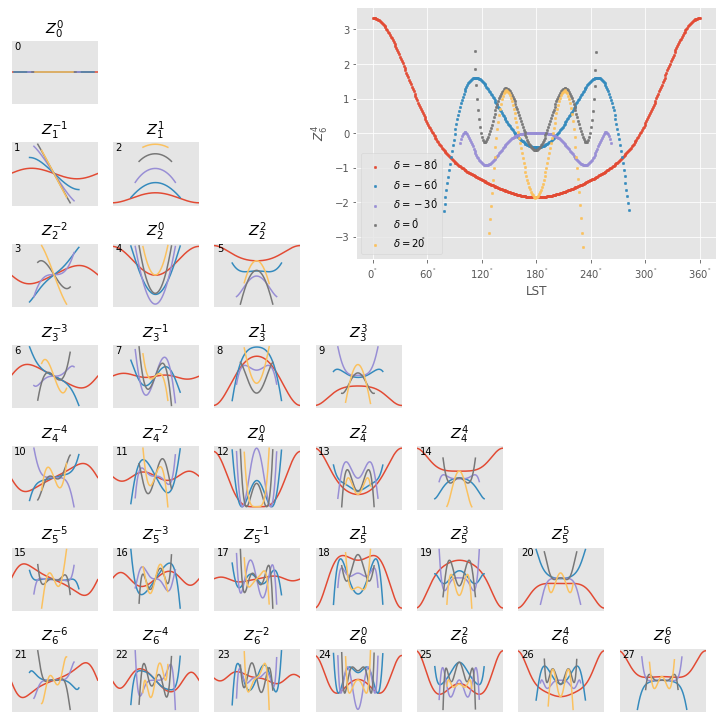

In [49]:
def plot_zernike_by_lst(zern_order, projection=None):
    zsky = lsst.sims.skybrightness_pre.zernike.ZernikeSky(order=zern_order, max_zd=70.5)
    z = zsky.healpix_z
    sphere_npix = healpy.nside2npix(zsky.nside)
    
    with plt.style.context('ggplot'):
        fig = plt.figure(figsize=(10, 10))
        big_ax = fig.add_axes((0.5, 0.65, 0.5, 0.35), projection=projection)

        n_terms = np.sum(np.arange(zsky.order) + 1)
        axes = []
        for j in np.arange(n_terms):
            n = np.ceil((-3 + np.sqrt(9 + 8 * j)) / 2).astype(int)
            mprime = 2 * j - n * (n + 2)
            m = np.abs(mprime)

            ax = fig.add_subplot(zsky.order, zsky.order, n*zsky.order+int((n+mprime)/2)+1, projection=projection)
            
            for decl in (-80, -60, -30, 0, 20):
                hpix = healpy.ang2pix(zsky.nside, 109, decl, lonlat=True)
                lst = np.arange(zsky.healpix_z.shape[0])
                if projection == 'polar':
                    lst = np.radians(lst)
                    
                pix_z = pd.DataFrame(
                        {'lst': lst, 
                         'z': zsky.healpix_z[:, hpix, j]})

                p = pix_z.plot('lst', 'z', ax=ax, legend=False)
                
                if j == 26:
                    big_ax.set_ylabel(f'$Z^{{{mprime}}}_{n}$')
                    big_p = big_ax.scatter(pix_z['lst'], pix_z['z'], s=6, label=rf'$\delta={decl}^{{\ocirc}}$')
                    big_ax.legend()
                    #big_p = pix_z.plot('lst', 'z', ax=big_ax,
                    #                   label=rf'$\delta={decl}^{{\ocirc}}$')
            
            ax.annotate(f'{j}', (0.04, 0.86), xycoords='axes fraction')
            if projection != "polar":
                ax.set_xlim(0, 360)
                
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_xticks([])
            #ax.set_xticklabels([])
            ax.set_yticks([])
            #ax.set_yticklabels([])
            ax.set_title(f'$Z^{{{mprime}}}_{n}$')
            axes.append(ax)
            
    big_ax.set_xlabel('LST')
    big_xticks = np.arange(0, 361, 60)
    big_ax.set_xticks(big_xticks)
    big_ax.set_xticklabels(f'{x} ' + r'$^{\ocirc}$' for x in big_xticks)
        
            
    plt.tight_layout()
    return fig, axes

fig, axes = plot_zernike_by_lst(7)

In [50]:
fig.savefig('Z_vs_LST.png')

# Zernike coefficient interpolation

In [51]:
zsky = lsst.sims.skybrightness_pre.zernike.ZernikeSky(order=7, max_zd=70.5)
zsky.load_coeffs('/data/des70.a/data/neilsen/ehn_lsst_scratch/sky_brightness/bulkzern_o7_z705.h5', 'i')

In [88]:
def plot_coeffs_by_lst(mjd_min, mjd_max):
    zsky = lsst.sims.skybrightness_pre.zernike.ZernikeSky(order=7, max_zd=70.5) 
    
    with plt.style.context('ggplot'):
        fig = plt.figure(figsize=(12, 12))

        axes = {}
        for band in 'ugrizy':
            color = BAND_COLOR[band]
            alpha = 1 if band=='i' else 0.25
            zsky.load_coeffs('/data/des70.a/data/neilsen/ehn_lsst_scratch/sky_brightness/bulkzern_o7_z705.h5', band)
            n_terms = np.sum(np.arange(zsky.order) + 1)
            night_coeffs = zsky._coeffs.loc[mjd_min:mjd_max].reset_index(drop=False)
            for j in np.arange(n_terms):
                n = np.ceil((-3 + np.sqrt(9 + 8 * j)) / 2).astype(int)
                mprime = 2 * j - n * (n + 2)
                m = np.abs(mprime)

                zscale = np.nanmax(np.abs(zsky.healpix_z[:, :, j]))
                
                try:
                    ax = axes[j]
                except KeyError:
                    ax = fig.add_subplot(zsky.order, zsky.order, n*zsky.order+int((n+mprime)/2)+1)
                    axes[j] = ax
                    
                if j==0:
                    ax.scatter(night_coeffs.mjd, night_coeffs[j], s=2, alpha=alpha, c=color)
                else:
                    ax.scatter(night_coeffs.mjd, night_coeffs[j]*zscale, s=2, alpha=alpha, c=color)
                    yrange = 2.4 if n<3 else 1.2 if n<5 else 0.4
                    ymin, ymax = -1*yrange/2, yrange/2
                    ax.set_ylim(ymin, ymax)
                    yticks = np.arange(ymin, ymax, yrange/8)
                    ax.set_yticks(yticks)
                    if mprime != -1*n:
                        ax.set_yticklabels('' for x in yticks)

                ax.annotate(f'{j}', (0.04, 0.86), xycoords='axes fraction')

                ax.set_ylabel('')
                ax.set_xlabel('')
                ax.set_xticks([])
                ax.set_title(f'$Z^{{{mprime}}}_{n}$')

    plt.tight_layout()
    return fig, axes

#mjd_start, mjd_end = sky.loc[60103.8:60104.6].query('sun_alt<-12').mjd.describe()[['min', 'max']]
#fig, axes = plot_coeffs_by_lst(mjd_start, mjd_end)

In [53]:
%%time
try:
    len(sky)
except:
    sky = pd.read_hdf('../data/resid_o7_z705_59823_60191.h5', 'i')

CPU times: user 25 s, sys: 28.3 s, total: 53.4 s
Wall time: 53.4 s


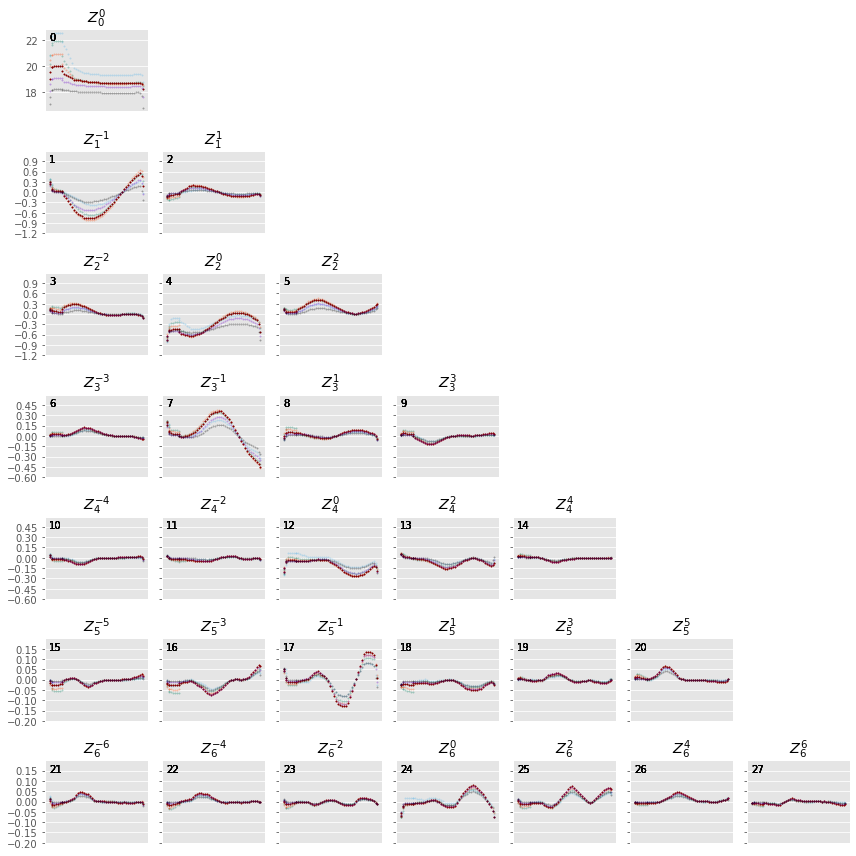

In [89]:
sample_mjd = Time('2023-06-07').mjd
mjd_start, mjd_end = sky.loc[sample_mjd-0.2:sample_mjd+0.8].query('sun_alt<-12').mjd.describe()[['min', 'max']]
fig, axes = plot_coeffs_by_lst(mjd_start, mjd_end)

In [79]:
fig.savefig('dynamic_coeff_vs_time.png')

Verify that the moons behaviour on this night is as described in the figure caption:

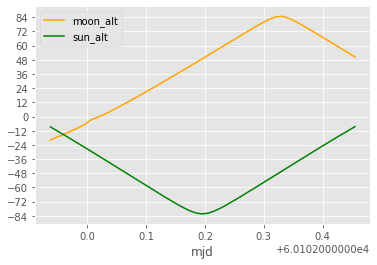

In [87]:
ax = sky.loc[sample_mjd-0.2:sample_mjd+0.8].query('sun_alt<0').plot('mjd', 'moon_alt', color='orange')
sky.loc[sample_mjd-0.2:sample_mjd+0.8].query('sun_alt<0').plot('mjd', 'sun_alt', color='green', ax=ax)
_ = ax.set_yticks(np.arange(-14*6, 15*6, 12))